In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import MLpipeline as ML
import MLmodelling as MLm
import pickle

%reload_ext autoreload
%autoreload 2
%matplotlib inline

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in

# Homework 3: Improving the Pipeline

## Dataset and ML Problem

DonorsChoose.org is an online charity that makes it easy to help students in need through school donations. At any time, thousands of teachers in K-12 schools propose projects requesting materials to enhance the education of their students. When a project reaches its funding goal, they ship the materials to the school.

The 2014 KDD Cup asks participants to help DonorsChoose.org identify projects that are exceptionally exciting to the business, at the time of posting. While all projects on the site fulfill some kind of need, certain projects have a quality above and beyond what is typical. By identifying and recommending such projects early, they will improve funding outcomes, better the user experience, and help more students receive the materials they need to learn.

We have data from projects and their outcomes from 2007 to 2013, at a daily frequency.<br> We will explore some trends on the whole dataset, but will only use data from 2013 to train computationally expensive predictors. <br><br>
The goal in this ML problem is to predict, at its posting time, __if a project will get or not fully funded__, so that we can intervene and help them improve the project listing. 

In [3]:
df_outc, df_outc_dups = ML.load_data('', 'outcomes.csv', format_ = 'csv', dups = True)
df_pr, df_pr_dups = ML.load_data('', 'projects.csv', format_ = 'csv', dups = True)

#### Outcomes dataset:

In [4]:
ML.overview(df_outc, df_outc_dups)

DATASET DIMENSIONS: 619326 rows , 12 cols 
 DUPLICATE ROWS: 0


projectid                                          object
is_exciting                                        object
at_least_1_teacher_referred_donor                  object
fully_funded                                       object
at_least_1_green_donation                          object
great_chat                                         object
three_or_more_non_teacher_referred_donors          object
one_non_teacher_referred_donor_giving_100_plus     object
donation_from_thoughtful_donor                     object
great_messages_proportion                         float64
teacher_referred_count                            float64
non_teacher_referred_count                        float64
dtype: object

#### Proyects dataset:

In [5]:
ML.overview(df_pr, df_pr_dups)

DATASET DIMENSIONS: 664098 rows , 35 cols 
 DUPLICATE ROWS: 0


projectid                                  object
teacher_acctid                             object
schoolid                                   object
school_ncesid                             float64
school_latitude                           float64
school_longitude                          float64
school_city                                object
school_state                               object
school_zip                                float64
school_metro                               object
school_district                            object
school_county                              object
school_charter                             object
school_magnet                              object
school_year_round                          object
school_nlns                                object
school_kipp                                object
school_charter_ready_promise               object
teacher_prefix                             object
teacher_teach_for_america                  object


Some of these column names are too long, so we will change them:

In [6]:
ML.rename_cols(df_pr, [1,2,4,5,17,19,20,21,22,23,24,28,29,30,32,33], ['teach_id', 'sch_id', 'sch_lat', 'sch_lon', 'sch_ch_prom',\
'teach4Am', 'teacher_nyfell','prim_foc_subj', 'prim_foc_area', 'sec_foc_subj', 'sec_foc_area',\
  'full_labor_mat' , 'tot_price_excl_supp', 'tot_price_incl_supp', 'elig_doub_imp','elig_alm_home'                                         ])

In [7]:
ML.rename_cols(df_outc, [2,4,6,7,8],['at_least1_teach_ref_don','at_least1_green_don', \
   '3_or_more_non_teacher_ref_don', '1non_teacher_ref_don_100plus','thoughtf_don' ])

Next, given that each project has a unique identifier in both datasets we can easily join the two on project id:

In [8]:
df = df_pr.join(df_outc, how='inner', lsuffix='', rsuffix='.outc')

## II. Exploration

In [9]:
df.shape

(619326, 47)

First, we can generate some basic time features that will be useful for exploration, in this case add a column capturing year, month, and day for each project's posting date:

In [10]:
ML.daytime_vals(df, 'date_posted', ['y', 'm', 'd','wd'])

We'll check what proportion of the projects ever posted have got full funding (since this will be our label, it's crucial to see how __balanced__ our dataset is):

In [11]:
ML.percents(df, 'fully_funded') # Most projects get funded

30.459% fully_funded f
69.541% fully_funded t


Also, it seems that the number (but not the proportion) of funded projects has gone up steadily over time:

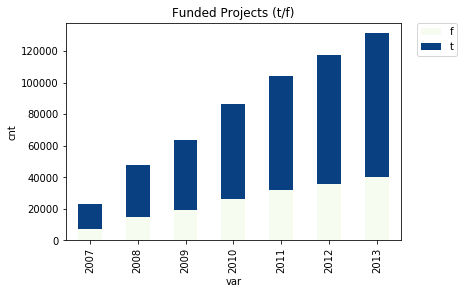

In [12]:
ML.graph_by_fact(df[df['date_posted_year']!=2014], 'fully_funded', 'date_posted_year', ['var','cnt'], 'Funded Projects (t/f)')

However, the __proportion__ of funded projects has fluctuated a bit over time:

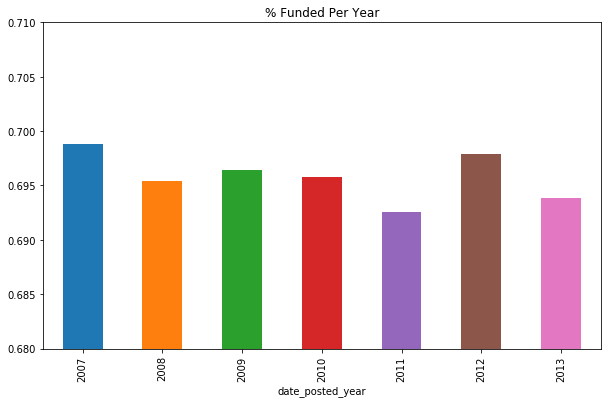

In [13]:
df_by_year = ML.plot_percents(df[df['date_posted_year'] != 2014], 'date_posted_year','fully_funded', 't', 0.68,0.71 ,\
                            '% Funded Per Year', (10,6), 'date_posted_year')

And, perhaps not unexpectedly, there is strong __seasonal variation__ in vacation times (winter and summer), as seen below. <br> But this graph tells us more: the month in which the project is posted doesn't seem to affect funding outcome, since both posted and full-funded projects seem to cycle together (April seems to be slightly better, though). We might then suspect that month is probably not a very predictive feature (that would be a _very_ premature conclusion, though).

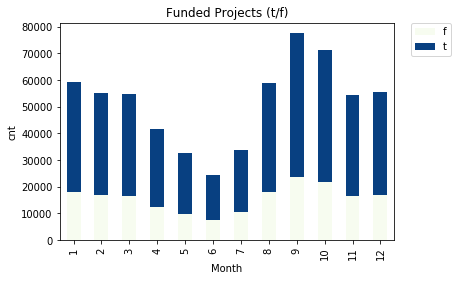

In [14]:
ML.graph_by_fact(df, 'fully_funded',  'date_posted_month', ['Month','cnt'], 'Funded Projects (t/f)')

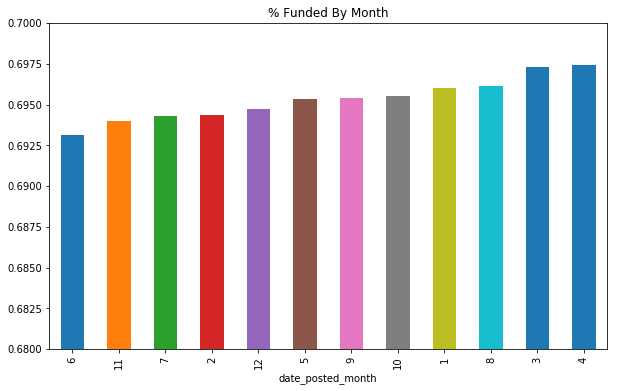

In [238]:
df_by_mnth = ML.plot_percents(df, 'date_posted_month','fully_funded', 't', 0.68,0.70 ,\
                            '% Funded By Month', (10,6))

It's important to notice these time trends. However, we will reduce the sample to only include 2011-2013 data for training our models:

In [15]:
dfsm = df[(df['date_posted_year'] >= 2011) & (df['date_posted_year'] <= 2013)]
dfsm.shape

(353151, 51)

Re-check the balance of the label value in the data:

In [16]:
ML.percents(dfsm, 'fully_funded') # Almost identical to the full 2007-2014 data!

30.519% fully_funded f
69.481% fully_funded t


And get some descriptive stats for the numerical variables in the dataset (which are the minority):

In [17]:
dfsm.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
school_ncesid,328293.0,2.503127e+11,1.648173e+11,1.000050e+10,6.372301e+10,2.400090e+11,3.904440e+11,6.100008e+11
sch_lat,353151.0,3.686856e+01,4.927417e+00,1.824914e+01,3.391639e+01,3.667583e+01,4.068049e+01,6.725816e+01
sch_lon,353151.0,-9.539832e+01,1.811836e+01,-1.716906e+02,-1.172468e+02,-8.988644e+01,-8.076190e+01,-6.662804e+01
school_zip,353151.0,5.630176e+04,3.104352e+04,4.100000e+02,2.938800e+04,6.061300e+04,9.000700e+04,9.992600e+04
full_labor_mat,353151.0,3.222031e+01,2.484309e+00,3.000000e+01,3.000000e+01,3.000000e+01,3.500000e+01,3.500000e+01
tot_price_excl_supp,353151.0,5.313724e+02,8.440694e+02,3.703000e+01,2.887500e+02,4.272700e+02,6.067200e+02,1.397254e+05
tot_price_incl_supp,353151.0,6.251440e+02,9.930228e+02,4.356000e+01,3.397100e+02,5.026700e+02,7.137900e+02,1.643828e+05
students_reached,353050.0,9.418717e+01,1.569874e+02,1.000000e+00,2.300000e+01,3.100000e+01,1.000000e+02,1.214300e+04
great_messages_proportion,250662.0,5.297314e+01,3.573648e+01,0.000000e+00,2.500000e+01,5.000000e+01,8.400000e+01,1.000000e+02
teacher_referred_count,299453.0,7.793811e-01,2.251626e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.510000e+02


Another clear trend: poorer schools tend to post much more projects:

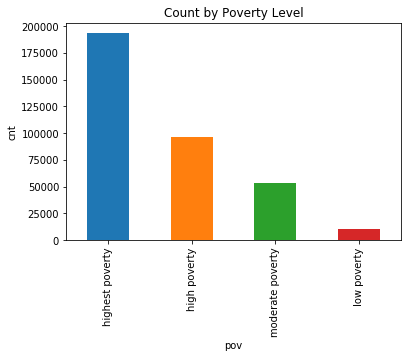

In [18]:
ML.count_by(dfsm, 'poverty_level', 'Count by Poverty Level', ['pov','cnt'])

But we don't observe  the same trend regarding actual __percentage__ of fully funded projects! Even though highest poverty schools have on average a higher funding rate, the next in line are low poverty schools, not high poverty ones:

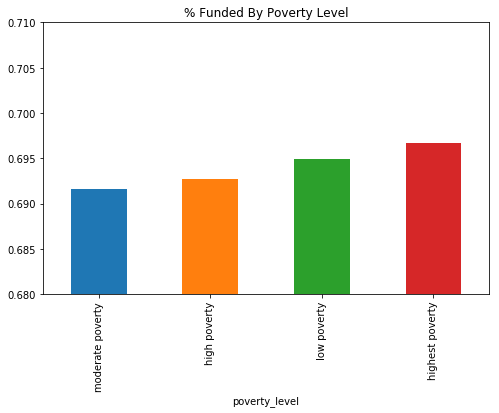

In [19]:
df_by_pov = ML.plot_percents(dfsm, 'poverty_level','fully_funded', 't', \
                             0.68,0.71 , '% Funded By Poverty Level')

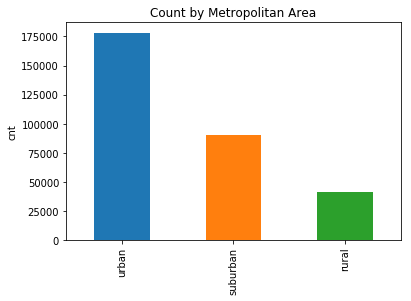

In [20]:
ML.count_by(dfsm, 'school_metro', 'Count by Metropolitan Area', ['','cnt'])

Again, the trend looks kind of different when looking at proportions instead of raw counts -- urban schools do get higher funding rates, but outcomes look more even among the three types.

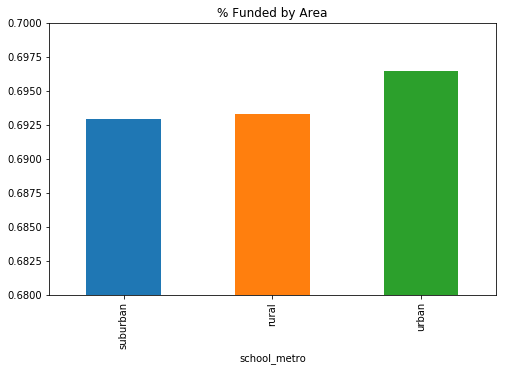

In [21]:
df_by_metrop = ML.plot_percents(dfsm, 'school_metro','fully_funded', 't', 0.68,0.7 ,\
                               '% Funded by Area')

Interestingly, all projects that were considered 'exciting' got fully funded (note that not every fully funded project was labelled as exciting). However, digging a bit deeper in the metadat, we can notice that this is an __ex-post__ variable that comes from the outcomes dataset, which means that using it as a feature would imply leakage, so it won't make sense to include it in our models later on:

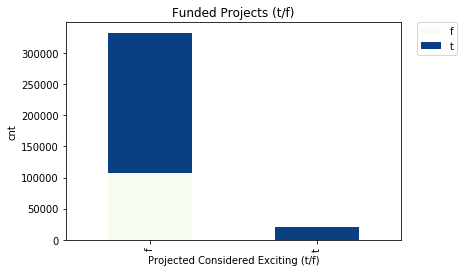

In [22]:
ML.graph_by_fact(dfsm, 'fully_funded', 'is_exciting', ['Projected Considered Exciting (t/f)',\
                                                     'cnt'],'Funded Projects (t/f)')

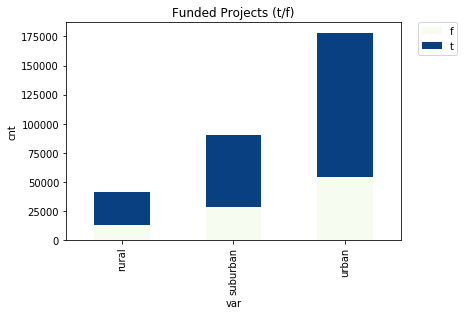

In [23]:
ML.graph_by_fact(dfsm,  'fully_funded','school_metro',  ['var','cnt'],'Funded Projects (t/f)')

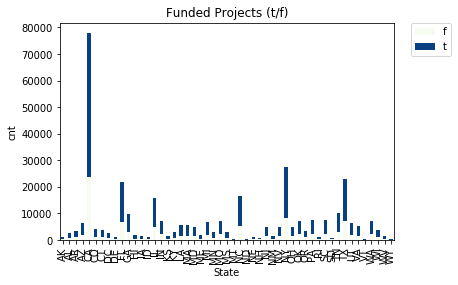

In [24]:
ML.graph_by_fact(dfsm, 'fully_funded','school_state' , ['State','cnt'], 'Funded Projects (t/f)')

Good to start with counts, but this often yields very limited information that might be misleading/superfluous  (larger states almost obviously send more projects because there are more people and schools) -- better to look at the __percentage__ of projects that were funded, given the state:

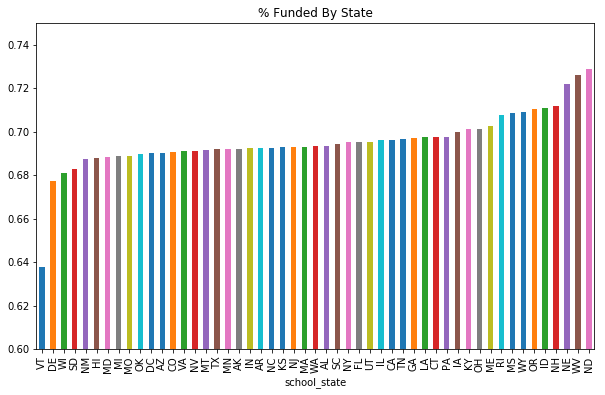

In [25]:
df_by_st = ML.plot_percents(dfsm, 'school_state','fully_funded', 't', 0.6,0.75 ,\
                            '% Funded By State', (10,6))

In [26]:
# We will save the 5 top states (as per % funded) for feature generation later:
states_freq = df_by_st.sort_values(by='Percent', ascending=False).head(5)
states_freq.index

Index(['ND', 'WV', 'NE', 'NH', 'ID'], dtype='object', name='school_state')

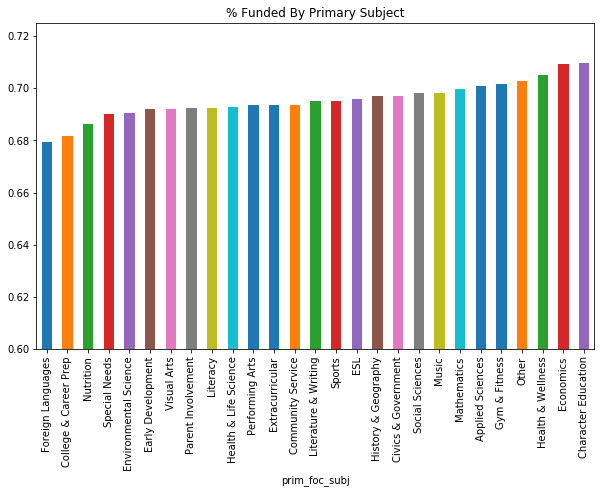

In [27]:
df_by_prim_subj = ML.plot_percents(dfsm, 'prim_foc_subj','fully_funded', 't',\
                                   0.6,0.725 , '% Funded By Primary Subject', (10,6))


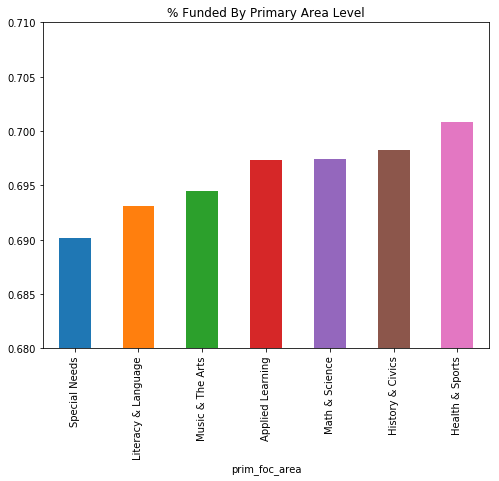

In [28]:
df_by_prim_area = ML.plot_percents(dfsm, 'prim_foc_area','fully_funded', 't',\
                                   0.68,0.71 , '% Funded By Primary Area Level',(8,6))

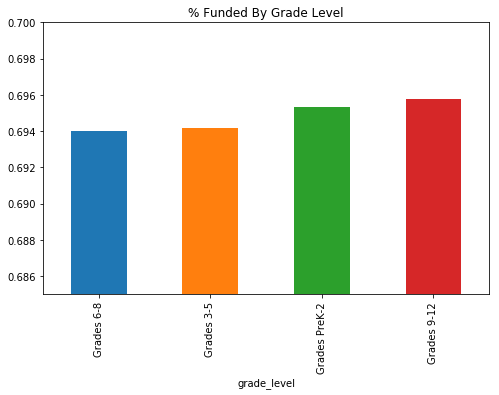

In [29]:
df_by_grade = ML.plot_percents(dfsm, 'grade_level','fully_funded', 't', 0.685,0.70 ,\
                               '% Funded By Grade Level')

Whether a teacher was from __'Teachers for America'__ or not doesn't seem correlated with funding outcome at first glance. But it might yield interesting interactions (donors networking labor?), so we will include it in the estimation, at least at the beginning:

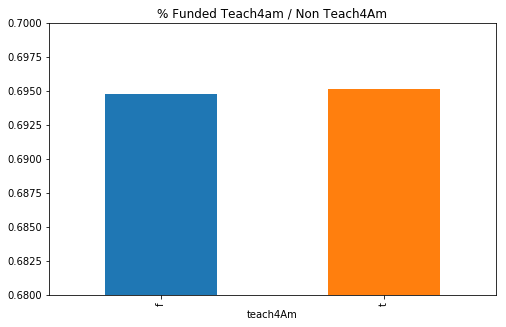

In [30]:
df_by_t4Am = ML.plot_percents(dfsm, 'teach4Am','fully_funded', 't', 0.68,.7 ,\
                               '% Funded Teach4am / Non Teach4Am')

The boolean variable __'great chat'__ summarizes the type of online comments a project generated since its posting, As it is the case with 'is_exciting', we won't add this variable as a feature because this happens ex post so we would be incurring in leakage, and hence, overfitting.<br> <br> This is also the case with non-teacher referrals and characteristic of external donors. In fact the only feature from the outcomes dataset that we will inlcude is teacher referral count.

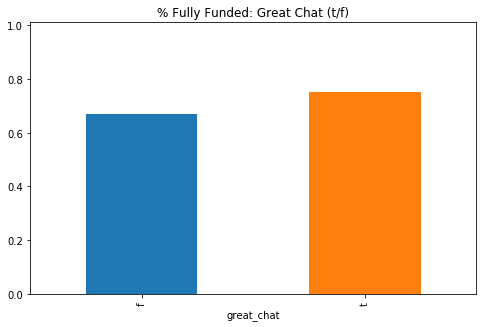

In [31]:
df_by_exc = ML.plot_percents(dfsm, 'great_chat','fully_funded', 't', 0.0, 1.01 ,\
                               '% Fully Funded: Great Chat (t/f)')


Even if the __teacher referral count__ is included in the outcomes dataset, it makes sense to keep it as a feature, as this is certainly something tyhat the teachers/project managers can handle a priori. <br> <br>
In fact, it could be an informative one for our alghorithm simnce the distributions for fully/non-fully funded projects is quite different -- fully funded propjects have a higher average number of referrals (and a much larger variance) as shown in the figure and table below:

/Users/elenabg/MLpipeline.py:389: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[var] = df[var].apply(lambda x: r if pd.isnull(x) else x)


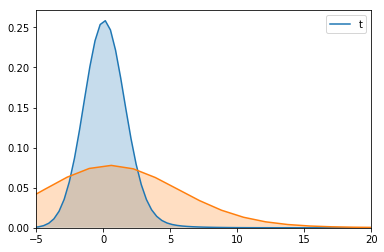

In [32]:
ML.simple_impute(dfsm, var = 'teacher_referred_count', val ='med')
ML.plot_mg_density(dfsm, 'teacher_referred_count', 2, 'fully_funded',  -5, 20, \
'Distribution of Teacher Referral Count for \n Fully Funded / Non-Fully Funded Projects')

In [33]:
ML.cond_stats(dfsm, ['teacher_referred_count', 'fully_funded'], 'fully_funded')

SUMMARY STATISTICS FOR TEACHER_REFERRED_COUNT by FULLY_FUNDED:


teacher_referred_count                                  
                               amin      mean median   amax       std
fully_funded                                                         
f                               0.0  0.166268    0.0   26.0  0.742165
t                               0.0  0.878124    0.0  151.0  2.429679

__Resource type__ seems to make a lot of difference, in terms of who gets full funding and who doesn't (funding for Visitors might sound 'exciting' for potential funders? Money for 'trips' might sound superflous to potential funders?). It makes complete sense to keep this as a feature.

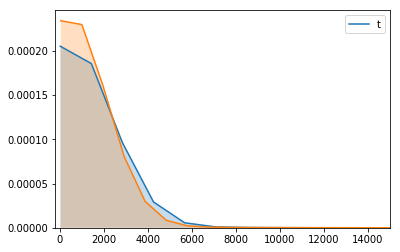

In [34]:
ML.plot_mg_density(dfsm, 'tot_price_excl_supp', 2, 'fully_funded' ,  -200, 15000, \
                   'Distribution of Teacher Referral Count for \n Fully Funded / Non-Fully Funded Projects')

In [35]:
ML.cond_stats(dfsm, ['tot_price_excl_supp', 'fully_funded'], 'fully_funded')

SUMMARY STATISTICS FOR TOT_PRICE_EXCL_SUPP by FULLY_FUNDED:


tot_price_excl_supp                                            
                            amin        mean   median       amax         std
fully_funded                                                                
f                          37.03  530.291951  425.765  139725.41  926.788499
t                          60.38  531.846938  427.720   94857.17  805.055164

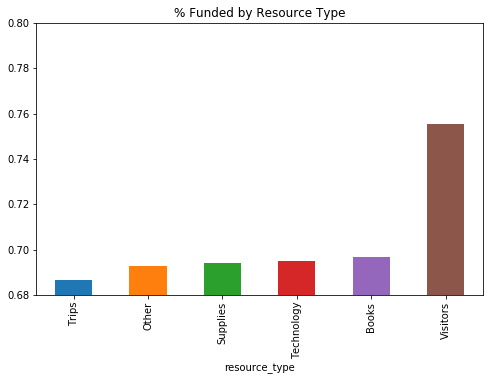

In [36]:
df_by_restype = ML.plot_percents(dfsm, 'resource_type','fully_funded', 't', 0.68,0.8 ,\
                               '% Funded by Resource Type')

Would the __teacher prefix__ matter? Perhaps a Mrs. gets lower funding (ceteris paribus) than a Mr. At a first glance, this is not the case but we will let the model decide.

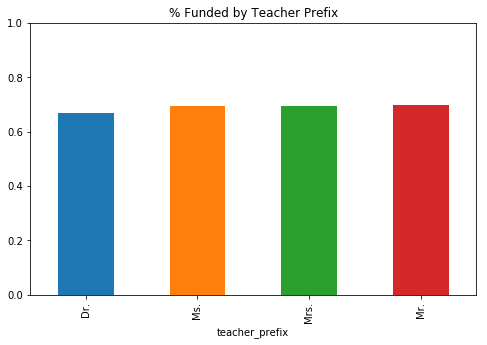

In [37]:
df_by_teacher_pref = ML.plot_percents(dfsm, 'teacher_prefix','fully_funded', 't', 0.0, 1 ,\
                               '% Funded by Teacher Prefix')

When looking at possible __spatial clustering__ of funding outcomes, we see that most project _postings_ cluster at the north and south. But at the center, the picture looks more uneven (bluer). This suggests that it makes sense to include __longitude__ as a feature:

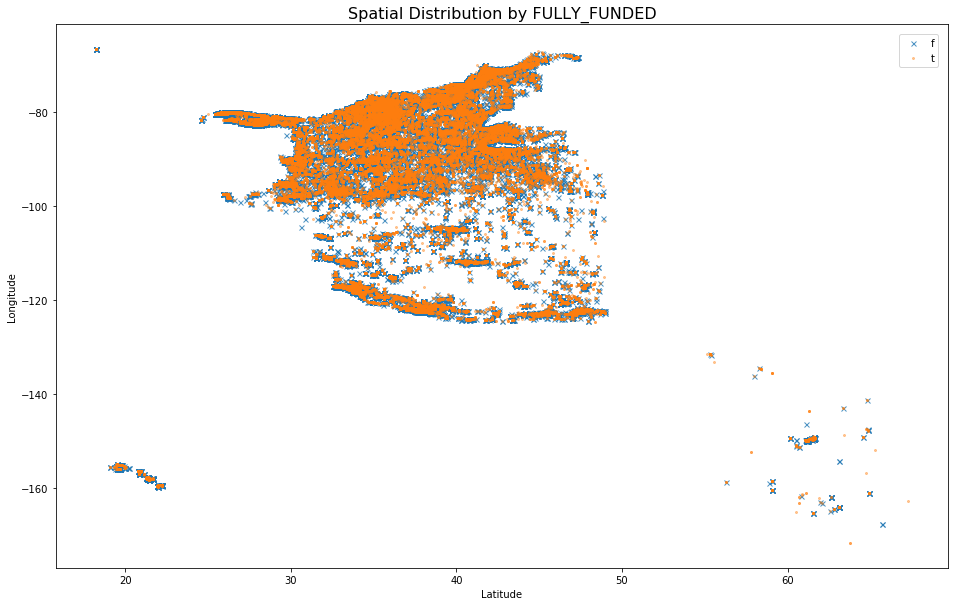

In [38]:
ML.spatial_scatter(dfsm,'fully_funded', 'sch_lat', 'sch_lon')

## III. Feature Generation and Pre-processing

First, we will add a cathegorical feature indicating state, if the school is in one of the top 5 states, and 'OTHER' otherwise. Later we will binarize it.

In [39]:
dfsm['state'] = dfsm['school_state'].apply(ML.others_dummy, args=(states_freq.index,))

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


### Impute missing values 

In order to be able to cathegorize variables we shouldn't have missing values. The correct way to do this is doing it on each training set (which in our case, we will be time splits). However, for now we'll use a naive apporach and just impute the mode on rows where there is at least one missing value:

In [40]:
null_rows = ML.na_vals(dfsm) # Check which cols and rows have missing vals

        school_ncesid school_metro                 school_district  \
44773    1.601530e+11        urban  Idaho Falls School District 91   
44775    5.103240e+11        urban   Richmond City School District   
44776    1.709930e+11        urban   Ravenswood-ridge Elem Network   
44777             NaN        urban      Florence School District 1   
44779    1.201980e+11        rural       Walton Co School District   
44780    1.201440e+11        urban    Orange Co Public School Dist   
44781    5.606090e+11        rural     Weston Co School District 7   
44782    3.600087e+11        urban        New York City Dept Of Ed   
44786    4.013800e+10          NaN     Buckeye Elem School Dist 33   
44787             NaN        urban      Michigan Dept of Education   
44791    8.054000e+10        urban       Thompson School Dist R2-j   
44792    5.103130e+11     suburban     Prince William Co Public SD   
44793    3.000005e+11          NaN        Helena School District 1   
44796    2.721390e+1

In [41]:
for v in null_rows:
    ML.simple_impute(dfsm, var = v, val = 'cat')
    

/Users/elenabg/MLpipeline.py:395: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[var] = df[var].apply(lambda x: r if pd.isnull(x) else x)


### Scalling

Scalling numerical features will also be extremely important for the performsance of our algorithms: a lot of the features in this dataset are cathegorical, and the few that are numerical have distinct units (which means, distinct meanings and interpretations).

In [42]:
var_to_std = ['sch_lat', 'sch_lon', 'school_ncesid', 'students_reached',\
              'tot_price_incl_supp']

In [43]:
for var in var_to_std:
    dfsm[var] = dfsm[var].apply(ML.standarize, args=(dfsm[var].mean(), dfsm[var].std()))

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


## IV. Feature Generation

### Binary features

The vast majority of this features are cathegorical, and to correctly process them we will have to represent them as binary variables, which means adding a columns for n-1 of the values each of these variables can take, yielding a sparse matrix. The columns that originally take just two possible values have their values simply translated to 1 or 0 ('dummified')

In [44]:
feats_to_dummify = ['teach4Am', 'school_kipp' , 'thoughtf_don', 'teacher_nyfell', 'elig_doub_imp',\
                 'elig_alm_home', 'fully_funded', 'at_least1_teach_ref_don'
                ]

In [45]:
ML.dummify(dfsm,feats_to_dummify)

/Users/elenabg/MLpipeline.py:497: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[name_d] = df[var].astype('category').cat.codes


In [46]:
feats_to_binarize = ['teacher_prefix','prim_foc_subj','prim_foc_area',
            'sec_foc_subj','sec_foc_area','poverty_level', 'resource_type','state',\
          'school_metro', 'grade_level',
           'date_posted_day_of_week']

In [47]:
for f in feats_to_binarize:
    ML.binarize(dfsm, f)
    ML.binarize(dfsm, f)

/Users/elenabg/MLpipeline.py:506: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[name_d] = np.where(df[var]== val, 1, 0)


Next, given that we have binary columns for all our variables of interest, we can drop the original columns (and others we won't use) to train our models:

In [48]:
df_est = dfsm.drop(['projectid', 'teach_id', 'sch_id','school_city', 'school_zip', 'teacher_prefix','prim_foc_subj','prim_foc_area',
       'sec_foc_subj','sec_foc_area','poverty_level', 'resource_type','state', 'school_state',\
        'school_metro', 'grade_level','teach4Am', 'school_kipp' , 'thoughtf_don', 'teacher_nyfell', 'elig_doub_imp',\
       'elig_alm_home', 'fully_funded','at_least1_teach_ref_don', 'at_least1_green_don','school_ncesid',\
       '3_or_more_non_teacher_ref_don', 'great_chat', 'school_district', 'school_county',
       'school_charter', 'school_magnet', 'school_year_round', 'school_nlns',
       'sch_ch_prom', 'full_labor_mat', 'tot_price_excl_supp', '1non_teacher_ref_don_100plus',\
       'date_posted_year','projectid.outc', 'thoughtf_don_dum', 'is_exciting', 'great_messages_proportion',
       'date_posted_day_of_week' , 'date_posted_day'], axis=1)

### Explore feature correlations

Exploring cross-correlations among features is often a good idea, in order to get a grasp of which features are expected to "determine" the value of the label beforehand (and contrast with our priors/intuitions),  <br>
From the above, we can see that some of the features that are most highly correlated with funding are related to referrals and type of donors: the first one is __non-teacher referral count__ (i.e number of referrals for the project made by people who weren't the teacher). Then we can see a high correlation between funding and whether or not the school is at the highest level of __poverty__. Of course, the most negative correlations matter just as much.

,correlation with fully_funded_dum
fully_funded_dum,1.000000
non_teacher_referred_count,0.268118
at_least1_teach_ref_don_dum,0.196645
teacher_referred_count,0.156679
highest poverty_dum,0.004555
Visitors_dum,0.004023
Mr._dum,0.003632
Parent Involvement_dum,0.003606
students_reached,0.003496
urban_dum,0.003004


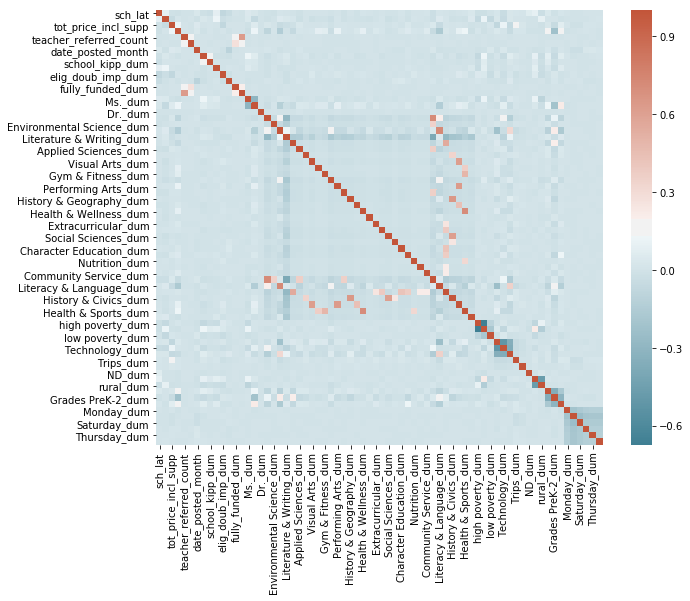

In [49]:
ML.top_corr(df_est, df_est.columns, 'fully_funded_dum', heatmap = True)

## V. Classify Using Time Windows

In [50]:
start_time = '2011-01-01'
first_cut = '2011-12-31'
sec_cut = '2012-12-31'
end_time = '2013-12-31'
small_cut = '2013-11-01'

Before we move on to our classification task (which will involve time validation) , we want to make sure the dataset is ordered by date of posting:

In [51]:
MLm.time_sort(df_est, 'date_posted')

Also, because some of the algorithms (especially SVM and KNN) are very expensive to run (costs grow more than proportionally to the size of training set), we'll keep a small subsample (last 2 months in the dataset) to try them all with varying parameters and thresholds:

In [52]:
df_small = df_est[df_est['date_posted'] >= small_cut]

In [53]:
df_small.shape

(25435, 71)

Now we are ready to estimate all the models we need, for any tresholds and time splits we want.

In [54]:
# full dataset
X, y = MLm.split(df_est, 'fully_funded_dum', ['date_posted'])
# small dataset for expensive algorithms
Xs, ys = MLm.split(df_small, 'fully_funded_dum', ['date_posted'])

In [55]:
# number of features
len(X.columns)

69

We will use we will use KNN, linear kernel SVM, random forests, linear regression, and AdaBoost with decision trees as base estimator, each with varying main parameters and twelve threshold values from 0 to 1:

In [56]:
thrs_s = [0, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
clfs_s = {'KNN':[1,5,10,25],  'SVM':[0.00001,0.001,0.1,1,10], 'RF':[10,20,50,100], 'LR':[0.1,1,10],\
        'LR2':[0.1,1,10], 'AB': [5,20,100],  'BaseL':['most_frequent']}

In [57]:
res_small = MLm.basic_time_loop(Xs, ys, clfs_s, thrs_s, 4, 'res_all.p')

Size of each time fold:  6358
Splitting the first 2 time folds at 1/2
Size of train + test:  (12716, 69)


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Model: KNN, Param: 1, K: 0, Metrics on time fold 2:, Precision = 0.0, Recall = 0.0
Splitting the first 3 time folds at 2/3
Size of train + test:  (19074, 69)
Model: KNN, Param: 1, K: 0, Metrics on time fold 3:, Precision = 0.0, Recall = 0.0
Splitting the first 4 time folds at 3/4
Size of train + test:  (25432, 69)
Model: KNN, Param: 1, K: 0, Metrics on time fold 4:, Precision = 0.0, Recall = 0.0
Size of each time fold:  6358
Splitting the first 2 time folds at 1/2
Size of train + test:  (12716, 69)
Model: KNN, Param: 1, K: 0.01, Metrics on time fold 2:, Precision = 0.8253968253968254, Recall = 0.011976047904191617
Splitting the first 3 time folds at 2/3
Size of train + test:  (19074, 69)
Model: KNN, Param: 1, K: 0.01, Metrics on time fold 3:, Precision = 0.6507936507936508, Recall = 0.009362868234756794
Splitting the first 4 time folds at 3/4
Size of train + test:  (25432, 69)
Model: KNN, Param: 1, K: 0.01, Metrics on time fold 4:, Precision = 0.6825396825396826, Recall = 0.00974393836

Model: KNN, Param: 5, K: 0.1, Metrics on time fold 3:, Precision = 0.9118110236220472, Recall = 0.1322219684859557
Splitting the first 4 time folds at 3/4
Size of train + test:  (25432, 69)
Model: KNN, Param: 5, K: 0.1, Metrics on time fold 4:, Precision = 0.8913385826771654, Recall = 0.12825742125538184
Size of each time fold:  6358
Splitting the first 2 time folds at 1/2
Size of train + test:  (12716, 69)
Model: KNN, Param: 5, K: 0.2, Metrics on time fold 2:, Precision = 0.8992918961447679, Recall = 0.2632427452786734
Splitting the first 3 time folds at 2/3
Size of train + test:  (19074, 69)
Model: KNN, Param: 5, K: 0.2, Metrics on time fold 3:, Precision = 0.9071597167584579, Recall = 0.2633021237725508
Splitting the first 4 time folds at 3/4
Size of train + test:  (25432, 69)
Model: KNN, Param: 5, K: 0.2, Metrics on time fold 4:, Precision = 0.8953579858379229, Recall = 0.2578744618173578
Size of each time fold:  6358
Splitting the first 2 time folds at 1/2
Size of train + test:  (

Model: KNN, Param: 10, K: 0.3, Metrics on time fold 3:, Precision = 0.9103303618248558, Recall = 0.396437542817995
Splitting the first 4 time folds at 3/4
Size of train + test:  (25432, 69)
Model: KNN, Param: 10, K: 0.3, Metrics on time fold 4:, Precision = 0.9140010487676979, Recall = 0.39496940856560164
Size of each time fold:  6358
Splitting the first 2 time folds at 1/2
Size of train + test:  (12716, 69)
Model: KNN, Param: 10, K: 0.4, Metrics on time fold 2:, Precision = 0.8922108575924469, Recall = 0.5223399355135883
Splitting the first 3 time folds at 2/3
Size of train + test:  (19074, 69)
Model: KNN, Param: 10, K: 0.4, Metrics on time fold 3:, Precision = 0.9000786782061369, Recall = 0.5224937200274035
Splitting the first 4 time folds at 3/4
Size of train + test:  (25432, 69)
Model: KNN, Param: 10, K: 0.4, Metrics on time fold 4:, Precision = 0.9016522423288749, Recall = 0.5193745751189667
Size of each time fold:  6358
Splitting the first 2 time folds at 1/2
Size of train + test

Model: KNN, Param: 25, K: 0.5, Metrics on time fold 3:, Precision = 0.8908118313404657, Recall = 0.646494633477963
Splitting the first 4 time folds at 3/4
Size of train + test:  (25432, 69)
Model: KNN, Param: 25, K: 0.5, Metrics on time fold 4:, Precision = 0.8904971680302077, Recall = 0.6412871062769091
Size of each time fold:  6358
Splitting the first 2 time folds at 1/2
Size of train + test:  (12716, 69)
Model: KNN, Param: 25, K: 0.6, Metrics on time fold 2:, Precision = 0.8500262191924489, Recall = 0.7466605251036389
Splitting the first 3 time folds at 2/3
Size of train + test:  (19074, 69)
Model: KNN, Param: 25, K: 0.6, Metrics on time fold 3:, Precision = 0.8563188253801783, Recall = 0.7458323818223339
Splitting the first 4 time folds at 3/4
Size of train + test:  (25432, 69)
Model: KNN, Param: 25, K: 0.6, Metrics on time fold 4:, Precision = 0.8581541688515993, Recall = 0.7416723317471108
Size of each time fold:  6358
Splitting the first 2 time folds at 1/2
Size of train + test:

Model: SVM, Param: 1e-05, K: 0.7, Metrics on time fold 3:, Precision = 0.7781523937963587, Recall = 0.7905914592372688
Splitting the first 4 time folds at 3/4
Size of train + test:  (25432, 69)
Model: SVM, Param: 1e-05, K: 0.7, Metrics on time fold 4:, Precision = 0.783771634075073, Recall = 0.790165420348969
Size of each time fold:  6358
Splitting the first 2 time folds at 1/2
Size of train + test:  (12716, 69)
Model: SVM, Param: 1e-05, K: 0.8, Metrics on time fold 2:, Precision = 0.735889872173058, Recall = 0.8618148318747121
Splitting the first 3 time folds at 2/3
Size of train + test:  (19074, 69)
Model: SVM, Param: 1e-05, K: 0.8, Metrics on time fold 3:, Precision = 0.7457227138643068, Recall = 0.8659511303950673
Splitting the first 4 time folds at 3/4
Size of train + test:  (25432, 69)
Model: SVM, Param: 1e-05, K: 0.8, Metrics on time fold 4:, Precision = 0.752802359882006, Recall = 0.86743711760707
Size of each time fold:  6358
Splitting the first 2 time folds at 1/2
Size of tra

Model: SVM, Param: 0.001, K: 0.9, Metrics on time fold 2:, Precision = 0.7135116238419856, Recall = 0.9401197604790419
Splitting the first 3 time folds at 2/3
Size of train + test:  (19074, 69)
Model: SVM, Param: 0.001, K: 0.9, Metrics on time fold 3:, Precision = 0.71123929382975, Recall = 0.9292075816396438
Splitting the first 4 time folds at 3/4
Size of train + test:  (25432, 69)
Model: SVM, Param: 0.001, K: 0.9, Metrics on time fold 4:, Precision = 0.7229505331235798, Recall = 0.9372309086789032
Size of each time fold:  6358
Splitting the first 2 time folds at 1/2
Size of train + test:  (12716, 69)
Model: SVM, Param: 0.001, K: 1, Metrics on time fold 2:, Precision = 0.6830265848670757, Recall = 1.0
Splitting the first 3 time folds at 2/3
Size of train + test:  (19074, 69)
Model: SVM, Param: 0.001, K: 1, Metrics on time fold 3:, Precision = 0.6888469403806827, Recall = 1.0
Splitting the first 4 time folds at 3/4
Size of train + test:  (25432, 69)
Model: SVM, Param: 0.001, K: 1, Metr

Model: SVM, Param: 1, K: 0, Metrics on time fold 2:, Precision = 0.0, Recall = 0.0
Splitting the first 3 time folds at 2/3
Size of train + test:  (19074, 69)
Model: SVM, Param: 1, K: 0, Metrics on time fold 3:, Precision = 0.0, Recall = 0.0
Splitting the first 4 time folds at 3/4
Size of train + test:  (25432, 69)
Model: SVM, Param: 1, K: 0, Metrics on time fold 4:, Precision = 0.0, Recall = 0.0
Size of each time fold:  6358
Splitting the first 2 time folds at 1/2
Size of train + test:  (12716, 69)
Model: SVM, Param: 1, K: 0.01, Metrics on time fold 2:, Precision = 0.9682539682539683, Recall = 0.014048825426070935
Splitting the first 3 time folds at 2/3
Size of train + test:  (19074, 69)
Model: SVM, Param: 1, K: 0.01, Metrics on time fold 3:, Precision = 0.9523809523809523, Recall = 0.013701758392327016
Splitting the first 4 time folds at 3/4
Size of train + test:  (25432, 69)
Model: SVM, Param: 1, K: 0.01, Metrics on time fold 4:, Precision = 0.9523809523809523, Recall = 0.01359619306

Model: SVM, Param: 10, K: 0.1, Metrics on time fold 3:, Precision = 0.9590551181102362, Recall = 0.1390728476821192
Splitting the first 4 time folds at 3/4
Size of train + test:  (25432, 69)
Model: SVM, Param: 10, K: 0.1, Metrics on time fold 4:, Precision = 0.9622047244094488, Recall = 0.13845456605483797
Size of each time fold:  6358
Splitting the first 2 time folds at 1/2
Size of train + test:  (12716, 69)
Model: SVM, Param: 10, K: 0.2, Metrics on time fold 2:, Precision = 0.9417781274586939, Recall = 0.2756794104099493
Splitting the first 3 time folds at 2/3
Size of train + test:  (19074, 69)
Model: SVM, Param: 10, K: 0.2, Metrics on time fold 3:, Precision = 0.9370574350904799, Recall = 0.27197990408769124
Splitting the first 4 time folds at 3/4
Size of train + test:  (25432, 69)
Model: SVM, Param: 10, K: 0.2, Metrics on time fold 4:, Precision = 0.9386309992132179, Recall = 0.27033763879447087
Size of each time fold:  6358
Splitting the first 2 time folds at 1/2
Size of train + t

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Model: RF, Param: 10, K: 0, Metrics on time fold 3:, Precision = 0.0, Recall = 0.0
Splitting the first 4 time folds at 3/4
Size of train + test:  (25432, 69)


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Model: RF, Param: 10, K: 0, Metrics on time fold 4:, Precision = 0.0, Recall = 0.0
Size of each time fold:  6358
Splitting the first 2 time folds at 1/2
Size of train + test:  (12716, 69)
Model: RF, Param: 10, K: 0.01, Metrics on time fold 2:, Precision = 0.9206349206349206, Recall = 0.013357899585444496
Splitting the first 3 time folds at 2/3
Size of train + test:  (19074, 69)
Model: RF, Param: 10, K: 0.01, Metrics on time fold 3:, Precision = 0.9047619047619048, Recall = 0.013016670472710665
Splitting the first 4 time folds at 3/4
Size of train + test:  (25432, 69)
Model: RF, Param: 10, K: 0.01, Metrics on time fold 4:, Precision = 0.9365079365079365, Recall = 0.013369589848175845
Size of each time fold:  6358
Splitting the first 2 time folds at 1/2
Size of train + test:  (12716, 69)
Model: RF, Param: 10, K: 0.1, Metrics on time fold 2:, Precision = 0.8677165354330708, Recall = 0.1269000460617227
Splitting the first 3 time folds at 2/3
Size of train + test:  (19074, 69)
Model: RF, Pa

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Model: RF, Param: 20, K: 0, Metrics on time fold 3:, Precision = 0.0, Recall = 0.0
Splitting the first 4 time folds at 3/4
Size of train + test:  (25432, 69)


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Model: RF, Param: 20, K: 0, Metrics on time fold 4:, Precision = 0.0, Recall = 0.0
Size of each time fold:  6358
Splitting the first 2 time folds at 1/2
Size of train + test:  (12716, 69)
Model: RF, Param: 20, K: 0.01, Metrics on time fold 2:, Precision = 0.9523809523809523, Recall = 0.013818516812528788
Splitting the first 3 time folds at 2/3
Size of train + test:  (19074, 69)
Model: RF, Param: 20, K: 0.01, Metrics on time fold 3:, Precision = 0.9206349206349206, Recall = 0.013245033112582781
Splitting the first 4 time folds at 3/4
Size of train + test:  (25432, 69)
Model: RF, Param: 20, K: 0.01, Metrics on time fold 4:, Precision = 0.8888888888888888, Recall = 0.012689780194878767
Size of each time fold:  6358
Splitting the first 2 time folds at 1/2
Size of train + test:  (12716, 69)
Model: RF, Param: 20, K: 0.1, Metrics on time fold 2:, Precision = 0.9102362204724409, Recall = 0.13311837862736067
Splitting the first 3 time folds at 2/3
Size of train + test:  (19074, 69)
Model: RF, P

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Model: RF, Param: 50, K: 0, Metrics on time fold 2:, Precision = 0.0, Recall = 0.0
Splitting the first 3 time folds at 2/3
Size of train + test:  (19074, 69)


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Model: RF, Param: 50, K: 0, Metrics on time fold 3:, Precision = 0.0, Recall = 0.0
Splitting the first 4 time folds at 3/4
Size of train + test:  (25432, 69)


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Model: RF, Param: 50, K: 0, Metrics on time fold 4:, Precision = 0.0, Recall = 0.0
Size of each time fold:  6358
Splitting the first 2 time folds at 1/2
Size of train + test:  (12716, 69)
Model: RF, Param: 50, K: 0.01, Metrics on time fold 2:, Precision = 0.9365079365079365, Recall = 0.013588208198986642
Splitting the first 3 time folds at 2/3
Size of train + test:  (19074, 69)
Model: RF, Param: 50, K: 0.01, Metrics on time fold 3:, Precision = 0.9047619047619048, Recall = 0.013016670472710665
Splitting the first 4 time folds at 3/4
Size of train + test:  (25432, 69)
Model: RF, Param: 50, K: 0.01, Metrics on time fold 4:, Precision = 0.9523809523809523, Recall = 0.013596193065941536
Size of each time fold:  6358
Splitting the first 2 time folds at 1/2
Size of train + test:  (12716, 69)
Model: RF, Param: 50, K: 0.1, Metrics on time fold 2:, Precision = 0.9023622047244094, Recall = 0.13196683555964994
Splitting the first 3 time folds at 2/3
Size of train + test:  (19074, 69)
Model: RF, P

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Model: RF, Param: 100, K: 0, Metrics on time fold 2:, Precision = 0.0, Recall = 0.0
Splitting the first 3 time folds at 2/3
Size of train + test:  (19074, 69)


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Model: RF, Param: 100, K: 0, Metrics on time fold 3:, Precision = 0.0, Recall = 0.0
Splitting the first 4 time folds at 3/4
Size of train + test:  (25432, 69)


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Model: RF, Param: 100, K: 0, Metrics on time fold 4:, Precision = 0.0, Recall = 0.0
Size of each time fold:  6358
Splitting the first 2 time folds at 1/2
Size of train + test:  (12716, 69)
Model: RF, Param: 100, K: 0.01, Metrics on time fold 2:, Precision = 0.8888888888888888, Recall = 0.012897282358360202
Splitting the first 3 time folds at 2/3
Size of train + test:  (19074, 69)
Model: RF, Param: 100, K: 0.01, Metrics on time fold 3:, Precision = 0.9365079365079365, Recall = 0.013473395752454898
Splitting the first 4 time folds at 3/4
Size of train + test:  (25432, 69)
Model: RF, Param: 100, K: 0.01, Metrics on time fold 4:, Precision = 0.9841269841269841, Recall = 0.014049399501472921
Size of each time fold:  6358
Splitting the first 2 time folds at 1/2
Size of train + test:  (12716, 69)
Model: RF, Param: 100, K: 0.1, Metrics on time fold 2:, Precision = 0.9118110236220472, Recall = 0.13334868724090282
Splitting the first 3 time folds at 2/3
Size of train + test:  (19074, 69)
Model: 

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Model: LR, Param: 0.1, K: 0, Metrics on time fold 4:, Precision = 0.0, Recall = 0.0
Size of each time fold:  6358
Splitting the first 2 time folds at 1/2
Size of train + test:  (12716, 69)
Model: LR, Param: 0.1, K: 0.01, Metrics on time fold 2:, Precision = 0.9523809523809523, Recall = 0.013818516812528788
Splitting the first 3 time folds at 2/3
Size of train + test:  (19074, 69)
Model: LR, Param: 0.1, K: 0.01, Metrics on time fold 3:, Precision = 0.9523809523809523, Recall = 0.013701758392327016
Splitting the first 4 time folds at 3/4
Size of train + test:  (25432, 69)
Model: LR, Param: 0.1, K: 0.01, Metrics on time fold 4:, Precision = 0.9682539682539683, Recall = 0.013822796283707228
Size of each time fold:  6358
Splitting the first 2 time folds at 1/2
Size of train + test:  (12716, 69)
Model: LR, Param: 0.1, K: 0.1, Metrics on time fold 2:, Precision = 0.9574803149606299, Recall = 0.14002763703362506
Splitting the first 3 time folds at 2/3
Size of train + test:  (19074, 69)
Model: 

Model: LR, Param: 1, K: 0.1, Metrics on time fold 4:, Precision = 0.9653543307086614, Recall = 0.13890777249036937
Size of each time fold:  6358
Splitting the first 2 time folds at 1/2
Size of train + test:  (12716, 69)
Model: LR, Param: 1, K: 0.2, Metrics on time fold 2:, Precision = 0.9457120377655389, Recall = 0.27683095347766007
Splitting the first 3 time folds at 2/3
Size of train + test:  (19074, 69)
Model: LR, Param: 1, K: 0.2, Metrics on time fold 3:, Precision = 0.9402045633359559, Recall = 0.27289335464717973
Splitting the first 4 time folds at 3/4
Size of train + test:  (25432, 69)
Model: LR, Param: 1, K: 0.2, Metrics on time fold 4:, Precision = 0.9417781274586939, Recall = 0.27124405166553367
Size of each time fold:  6358
Splitting the first 2 time folds at 1/2
Size of train + test:  (12716, 69)
Model: LR, Param: 1, K: 0.3, Metrics on time fold 2:, Precision = 0.9260618772941793, Recall = 0.40672501151543067
Splitting the first 3 time folds at 2/3
Size of train + test:  (1

Model: LR, Param: 10, K: 0.3, Metrics on time fold 4:, Precision = 0.934976402726796, Recall = 0.4040335372762293
Size of each time fold:  6358
Splitting the first 2 time folds at 1/2
Size of train + test:  (12716, 69)
Model: LR, Param: 10, K: 0.4, Metrics on time fold 2:, Precision = 0.9083398898505114, Recall = 0.5317825886688162
Splitting the first 3 time folds at 2/3
Size of train + test:  (19074, 69)
Model: LR, Param: 10, K: 0.4, Metrics on time fold 3:, Precision = 0.9138473642800944, Recall = 0.5304864124229276
Splitting the first 4 time folds at 3/4
Size of train + test:  (25432, 69)
Model: LR, Param: 10, K: 0.4, Metrics on time fold 4:, Precision = 0.911093627065303, Recall = 0.5248130523453433
Size of each time fold:  6358
Splitting the first 2 time folds at 1/2
Size of train + test:  (12716, 69)
Model: LR, Param: 10, K: 0.5, Metrics on time fold 2:, Precision = 0.8845185651353052, Recall = 0.6473975126669738
Splitting the first 3 time folds at 2/3
Size of train + test:  (190

Model: LR2, Param: 0.1, K: 0.5, Metrics on time fold 4:, Precision = 0.895846444304594, Recall = 0.6451393609789259
Size of each time fold:  6358
Splitting the first 2 time folds at 1/2
Size of train + test:  (12716, 69)
Model: LR2, Param: 0.1, K: 0.6, Metrics on time fold 2:, Precision = 0.8620870477189303, Recall = 0.7572547213265776
Splitting the first 3 time folds at 2/3
Size of train + test:  (19074, 69)
Model: LR2, Param: 0.1, K: 0.6, Metrics on time fold 3:, Precision = 0.8710015731515469, Recall = 0.7586206896551724
Splitting the first 4 time folds at 3/4
Size of train + test:  (25432, 69)
Model: LR2, Param: 0.1, K: 0.6, Metrics on time fold 4:, Precision = 0.8775563712637651, Recall = 0.758440969861772
Size of each time fold:  6358
Splitting the first 2 time folds at 1/2
Size of train + test:  (12716, 69)
Model: LR2, Param: 0.1, K: 0.7, Metrics on time fold 2:, Precision = 0.8109687570240504, Recall = 0.8309534776600644
Splitting the first 3 time folds at 2/3
Size of train + t

Model: LR2, Param: 1, K: 0.8, Metrics on time fold 3:, Precision = 0.7638151425762045, Recall = 0.8869604932633022
Splitting the first 4 time folds at 3/4
Size of train + test:  (25432, 69)
Model: LR2, Param: 1, K: 0.8, Metrics on time fold 4:, Precision = 0.7734513274336283, Recall = 0.8912304554724677
Size of each time fold:  6358
Splitting the first 2 time folds at 1/2
Size of train + test:  (12716, 69)
Model: LR2, Param: 1, K: 0.9, Metrics on time fold 2:, Precision = 0.7161335430868729, Recall = 0.9435743896821741
Splitting the first 3 time folds at 2/3
Size of train + test:  (19074, 69)
Model: LR2, Param: 1, K: 0.9, Metrics on time fold 3:, Precision = 0.718930256948086, Recall = 0.9392555377940169
Splitting the first 4 time folds at 3/4
Size of train + test:  (25432, 69)
Model: LR2, Param: 1, K: 0.9, Metrics on time fold 4:, Precision = 0.7280195769970285, Recall = 0.9438024019941084
Size of each time fold:  6358
Splitting the first 2 time folds at 1/2
Size of train + test:  (12

Model: LR2, Param: 10, K: 1, Metrics on time fold 4:, Precision = 0.6941953751769703, Recall = 1.0
Size of each time fold:  6358
Splitting the first 2 time folds at 1/2
Size of train + test:  (12716, 69)


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Model: AB, Param: 5, K: 0, Metrics on time fold 2:, Precision = 0.0, Recall = 0.0
Splitting the first 3 time folds at 2/3
Size of train + test:  (19074, 69)


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Model: AB, Param: 5, K: 0, Metrics on time fold 3:, Precision = 0.0, Recall = 0.0
Splitting the first 4 time folds at 3/4
Size of train + test:  (25432, 69)


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Model: AB, Param: 5, K: 0, Metrics on time fold 4:, Precision = 0.0, Recall = 0.0
Size of each time fold:  6358
Splitting the first 2 time folds at 1/2
Size of train + test:  (12716, 69)
Model: AB, Param: 5, K: 0.01, Metrics on time fold 2:, Precision = 0.8412698412698413, Recall = 0.012206356517733764
Splitting the first 3 time folds at 2/3
Size of train + test:  (19074, 69)
Model: AB, Param: 5, K: 0.01, Metrics on time fold 3:, Precision = 0.8412698412698413, Recall = 0.012103219913222198
Splitting the first 4 time folds at 3/4
Size of train + test:  (25432, 69)
Model: AB, Param: 5, K: 0.01, Metrics on time fold 4:, Precision = 0.9206349206349206, Recall = 0.013142986630410152
Size of each time fold:  6358
Splitting the first 2 time folds at 1/2
Size of train + test:  (12716, 69)
Model: AB, Param: 5, K: 0.1, Metrics on time fold 2:, Precision = 0.8582677165354331, Recall = 0.12551819438046982
Splitting the first 3 time folds at 2/3
Size of train + test:  (19074, 69)
Model: AB, Param:

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Model: AB, Param: 20, K: 0, Metrics on time fold 2:, Precision = 0.0, Recall = 0.0
Splitting the first 3 time folds at 2/3
Size of train + test:  (19074, 69)


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Model: AB, Param: 20, K: 0, Metrics on time fold 3:, Precision = 0.0, Recall = 0.0
Splitting the first 4 time folds at 3/4
Size of train + test:  (25432, 69)


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Model: AB, Param: 20, K: 0, Metrics on time fold 4:, Precision = 0.0, Recall = 0.0
Size of each time fold:  6358
Splitting the first 2 time folds at 1/2
Size of train + test:  (12716, 69)
Model: AB, Param: 20, K: 0.01, Metrics on time fold 2:, Precision = 0.873015873015873, Recall = 0.012666973744818056
Splitting the first 3 time folds at 2/3
Size of train + test:  (19074, 69)
Model: AB, Param: 20, K: 0.01, Metrics on time fold 3:, Precision = 0.8253968253968254, Recall = 0.01187485727335008
Splitting the first 4 time folds at 3/4
Size of train + test:  (25432, 69)
Model: AB, Param: 20, K: 0.01, Metrics on time fold 4:, Precision = 0.8888888888888888, Recall = 0.012689780194878767
Size of each time fold:  6358
Splitting the first 2 time folds at 1/2
Size of train + test:  (12716, 69)
Model: AB, Param: 20, K: 0.1, Metrics on time fold 2:, Precision = 0.8850393700787401, Recall = 0.1294334408106863
Splitting the first 3 time folds at 2/3
Size of train + test:  (19074, 69)
Model: AB, Para

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Model: AB, Param: 100, K: 0, Metrics on time fold 2:, Precision = 0.0, Recall = 0.0
Splitting the first 3 time folds at 2/3
Size of train + test:  (19074, 69)


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Model: AB, Param: 100, K: 0, Metrics on time fold 3:, Precision = 0.0, Recall = 0.0
Splitting the first 4 time folds at 3/4
Size of train + test:  (25432, 69)


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Model: AB, Param: 100, K: 0, Metrics on time fold 4:, Precision = 0.0, Recall = 0.0
Size of each time fold:  6358
Splitting the first 2 time folds at 1/2
Size of train + test:  (12716, 69)
Model: AB, Param: 100, K: 0.01, Metrics on time fold 2:, Precision = 0.9206349206349206, Recall = 0.013357899585444496
Splitting the first 3 time folds at 2/3
Size of train + test:  (19074, 69)
Model: AB, Param: 100, K: 0.01, Metrics on time fold 3:, Precision = 0.8412698412698413, Recall = 0.012103219913222198
Splitting the first 4 time folds at 3/4
Size of train + test:  (25432, 69)
Model: AB, Param: 100, K: 0.01, Metrics on time fold 4:, Precision = 0.9047619047619048, Recall = 0.01291638341264446
Size of each time fold:  6358
Splitting the first 2 time folds at 1/2
Size of train + test:  (12716, 69)
Model: AB, Param: 100, K: 0.1, Metrics on time fold 2:, Precision = 0.8834645669291339, Recall = 0.12920313219714416
Splitting the first 3 time folds at 2/3
Size of train + test:  (19074, 69)
Model: A

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Model: BaseL, Param: most_frequent, K: 0.4, Metrics on time fold 3:, Precision = 0.6723052714398112, Recall = 0.39027175154144783
Splitting the first 4 time folds at 3/4
Size of train + test:  (25432, 69)
Model: BaseL, Param: most_frequent, K: 0.4, Metrics on time fold 4:, Precision = 0.6888276947285602, Recall = 0.3967822343077272
Size of each time fold:  6358
Splitting the first 2 time folds at 1/2
Size of train + test:  (12716, 69)
Model: BaseL, Param: most_frequent, K: 0.5, Metrics on time fold 2:, Precision = 0.6815607300188798, Recall = 0.49884845693228924
Splitting the first 3 time folds at 2/3
Size of train + test:  (19074, 69)
Model: BaseL, Param: most_frequent, K: 0.5, Metrics on time fold 3:, Precision = 0.6806167400881057, Recall = 0.4939483900433889
Splitting the first 4 time folds at 3/4
Size of train + test:  (25432, 69)
Model: BaseL, Param: most_frequent, K: 0.5, Metrics on time fold 4:, Precision = 0.6950912523599748, Recall = 0.5005665080444143
Size of each time fold:

## VI. Results and Performance Analysis

In this section we'll analyze and compare the performance of the different classifiers we obtained, across different metrics.

In [59]:
res_small.head()

,model,parameter,K,precision,recall,ROC
0,KNN,1,0,0.000000,0.000000,0.500000
1,KNN,1,0.01,0.719577,0.010361,0.500702
2,KNN,1,0.1,0.753281,0.109270,0.515028
3,KNN,1,0.2,0.755049,0.219214,0.530924
4,KNN,1,0.3,0.755987,0.329308,0.547073


In [60]:
res_small.tail()

,model,parameter,K,precision,recall,ROC
271,BaseL,most_frequent,0.6,0.686593,0.598143,0.497066
272,BaseL,most_frequent,0.7,0.687046,0.698181,0.497331
273,BaseL,most_frequent,0.8,0.687250,0.798241,0.497300
274,BaseL,most_frequent,0.9,0.687409,0.898292,0.497286
275,BaseL,most_frequent,1,0.688690,1.000000,0.500000


### 0. Baseline Prediction

For benchmark comparison (we should make sure all this work is better than costlessly flipping a coin) we estimated the __baseline predictor__ by fitting a dummy classifier of the 'most frequent" class to the training set, for every time fold and threshold. <br> Its average precision and recall were __0.634, 0.458__, respectively. As we will see, for all threshold we considered relevant(i.e. larger than zero and less than 1, with ten equal discrete increments) the __baseline had a worse precision-recall trade-off and worse ROC score__ than all our ML models. Good to know!

In [61]:
av_baseline_prec = res_small[res_small['model']=='BaseL']['precision'].mean()
av_baseline_rec = res_small[res_small['model']=='BaseL']['recall'].mean()

In [62]:
av_baseline_prec, av_baseline_rec

(0.6340886255554905, 0.4578610536497343)

### 1. Random Forest

First thing to notice is that, compared to our baseline predictor, all RF models perform considerably better, the best one (i.e. the one further wawy from the origin) being __n=100__ for all relevant thresholds.

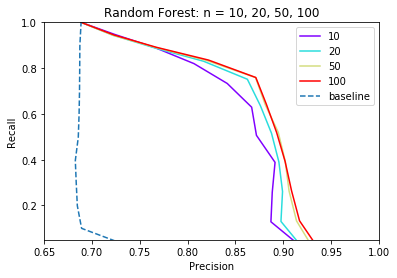

In [213]:
MLm.plot_model(res_small, 'RF', [10, 20, 50, 100], xmin=0.65, ymin =0.05, ymax=1,
               title='Random Forest: n = 10, 20, 50, 100', baseline=True)

Our __ROC score__ function computes the area under the receiver operating characteristic (ROC) curve, denoted by AUC . <br> <br> By computing the __area under the ROC curve__, all of the curve information we need to evaluate and compare our models is conveniently summarized in one number, whose __variation along the threshold k__ we want to explore for every case:

For all RF, the best perfoming under this metrics was, again, n=100 with AUC maximized at threshold k ~ 0.60.

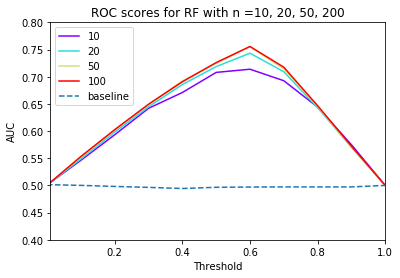

In [215]:
MLm.plot_roc(res_small, 'RF', [10, 20, 50, 100], xmin=0.01, ymin=0.40, ymax=0.80,
             title='ROC scores for RF with n =10, 20, 50, 200', baseline = True)

Below we can see that precision and recall cross around threshold k = 0.70 for all RF. In addition, for the k that maximizes ROC score (which would be our preferred one, k* =0.60 with n=100) __precision is about is approx 0.81 and recall is approx. 0.73.__

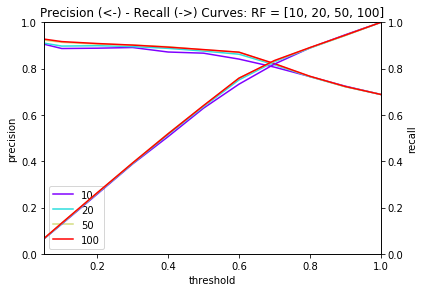

In [211]:
MLm.plot_precision_recall(res_small, 'RF', [10, 20, 50, 100])

### 2. Logistic Regression

Even if results for different parameters are much more similar than among RF, we do notice a best perfoming model among LR here: __l1 and C = 0.1__.

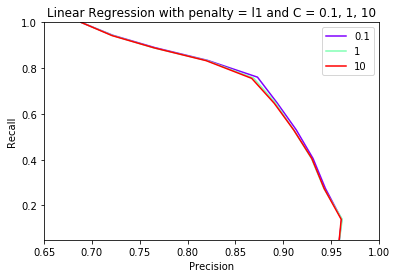

In [210]:
MLm.plot_model(res_small, 'LR', [0.1,1,10], 0.65, 1, 0.05, 1, \
               'Linear Regression with penalty = l1 and C = 0.1, 1, 10')

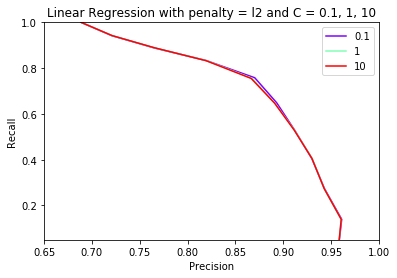

In [209]:
MLm.plot_model(res_small, 'LR2', [0.1,1,10], 0.65, 1, 0.05, 1, \
               'Linear Regression with penalty = l2 and C = 0.1, 1, 10')

Such model is also the one that yields maximal AUC , at __k\* ~ 0.58__ and __AUC\* ~ 0.765__.

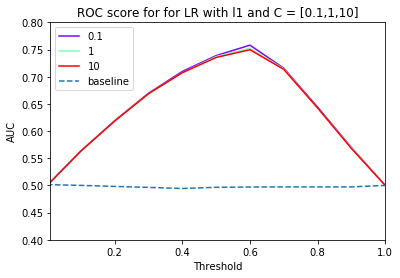

In [208]:
MLm.plot_roc(res_small, 'LR', [0.1,1,10], 0.01, 1, 0.40, 0.80,
             title='ROC score for for LR with l1 and C = [0.1,1,10]', baseline=True)

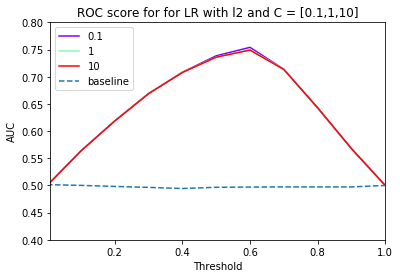

In [207]:
MLm.plot_roc(res_small, 'LR2', [0.1,1,10], 0.01, 1, 0.40, 0.80,
             title='ROC score for for LR with l2 and C = [0.1,1,10]', baseline=True)

All 6 variation for LR we estimated are _very_ similar in terms of their precision-recall tradeoff:

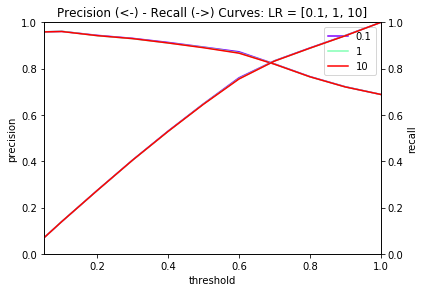

In [206]:
MLm.plot_precision_recall(res_small, 'LR', [0.1, 1,10])

However, we can always zoom in at the optimal threshold k\* and visualize the small yet existing differences. __Precision at k* is ~ 0.87 while recall is ~ 0.92__. Better than the best RF under all our metrics:

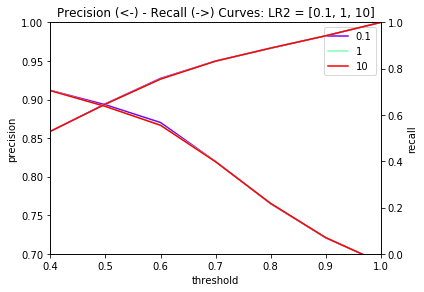

In [230]:
MLm.plot_precision_recall(res_small, 'LR2', [0.1, 1,10], xmin=0.4, ymin=0.7)

### 3. AdaBoost with DT

For the boosting algorithm we tried here (AdaBoost), the picture is not as clear, as varying thresholds also varies the best model choice we can make:

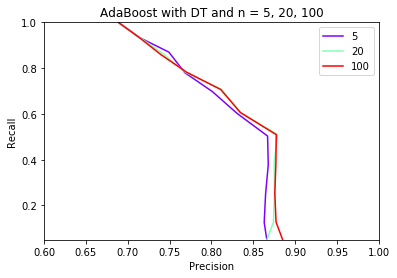

In [204]:
MLm.plot_model(res_small, 'AB', [5, 20, 100], 0.6, 1, 0.05, 1, \
               'AdaBoost with DT and n = 5, 20, 100')

If we were, for some reason, interested in a target threshold k < 0.70, we should pick AB with n=100. For k >=0.70 we might be better off with n=5, as seen below. However, given our ML goal and the balance in our sample (where about 65% of the projects get fully funded), we have no reason to be interested in a k > 0.70. <br> Therefore, __among AB models we'd pick n=100__ at k\* = 0.40. <br> Notice in the graphs below however that, overall, __AB models perform worse than our best LR and RF__. Recall is particularly poor along the threshold line:

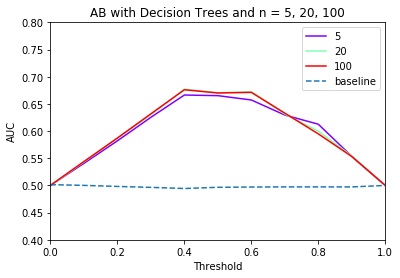

In [203]:
MLm.plot_roc(res_small, 'AB', [5, 20, 100], ymin=0.40, ymax=.80,
             title='AB with Decision Trees and n = 5, 20, 100', baseline=True)

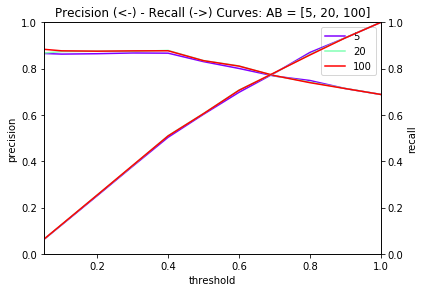

In [202]:
MLm.plot_precision_recall(res_small, 'AB',[5, 20, 100])

### 4. KNN

For KNN (with euclidean distance), judging by the precision-recall tradeoff we find an uncontroversially better model, at k_neigb = 25.

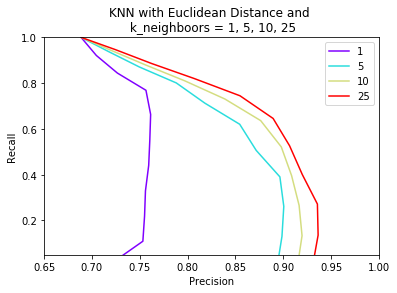

In [201]:
MLm.plot_model(res_small, 'KNN', [1,5,10,25], 0.65, 1, 0.05, 1, \
               'KNN with Euclidean Distance and \n k_neighboors = 1, 5, 10, 25')

Moreover, k_neigh=25 maximizes AUC along all relevant threshold values, being maximal at k\* ~ 0.45 and __AUC\* ~ 0.725_.

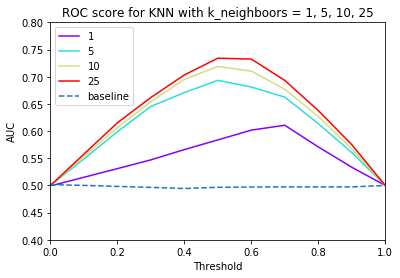

In [199]:
MLm.plot_roc(res_small, 'KNN', [1,5,10,25], 0, 1, 0.4, 0.8,\
             title='ROC score for KNN with k_neighboors = 1, 5, 10, 25', baseline=True)

At k\*, precision for k_neigh = 25 is 0.91 and recall is approx 0.60. Overall, better than baseline, but __still worse than LR l1 , C = 0.1__.

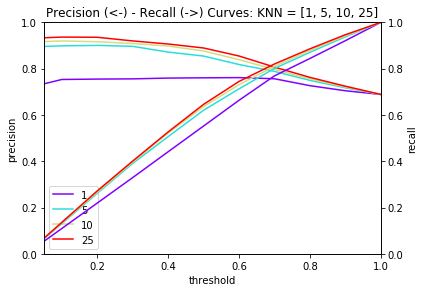

In [198]:
MLm.plot_precision_recall(res_small, 'KNN',[1,5,10, 25])

### 5. SVM

Finally, performance metrics for linear kernel SVM that the best among the five is  __C = 10__, with the best precision-recall ytradeoof along threshold line and yielding __maximal AUC ~ 0.73 at k\* = 0.60__.

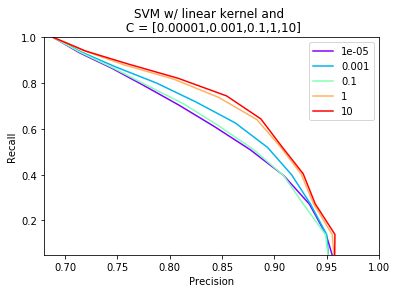

In [231]:
MLm.plot_model(res_small, 'SVM', [0.00001,0.001,0.1,1,10], 0.68, 1, 0.05, 1, \
               'SVM w/ linear kernel and \n C = [0.00001,0.001,0.1,1,10]')

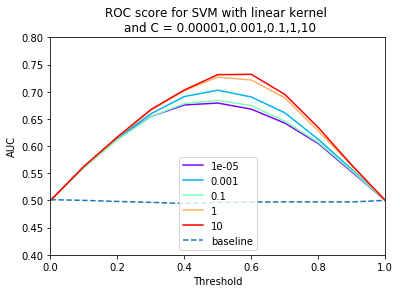

In [196]:
MLm.plot_roc(res_small, 'SVM', [0.00001,0.001,0.1,1,10], 0, 1, 0.40, 0.80,\
             title='ROC score for SVM with linear kernel \n and C = 0.00001,0.001,0.1,1,10',
            baseline=True)

At k\*, C=10 has precision ~ 0.90 and recall ~ 0.70. Still, overall worse than LR l1, C=0.1

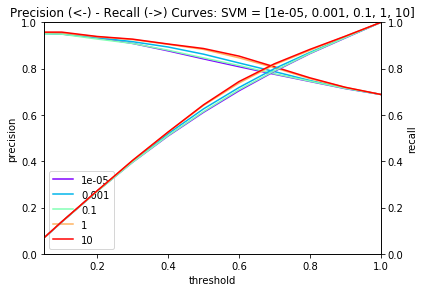

In [197]:
MLm.plot_precision_recall(res_small, 'SVM', [0.00001, 0.001, 0.1, 1, 10])

### Feature Importance

As a final step, before giving policy recommendations, it's useful to quantify the __importance of each feature__ in the model in an objective but intuitive way. We can do so easily using random forest at n=100 (the best RF we fitted) to extract and rank the features that "feed the model" with most information. 

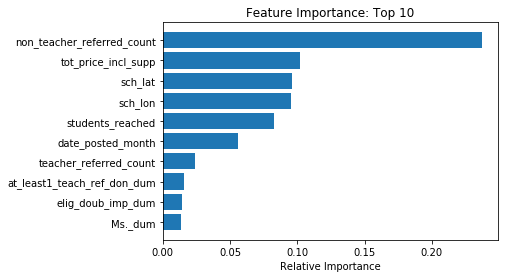

In [233]:
ML.plot_importances(df_est, X.columns, 'fully_funded_dum', \
                    n=10, title='Feature Importance: Top 10')

While some of these results are in line with the correlations we explored previously, this importance ranking gives us a lot of new and valuable information. <br><br> As shown above, the most relevant predictor is, by far, the number of referrals made by non-teachers (in line with heatmap). Second to fifth (with nearly the same relevance), the total __cost__ of the project, the __geographical location__ of the school, and the number of students impacted by the project (all of these were not in the top correlations!). After the sixth top feature, importance begins to decrease substantially, that's why we only look at the top ten ones (there are __69__ in total!)  <br><br>
It seems that, all in all, the __month__ when the project is posted is relatively important, as is whether the __teacher's prefix__ is Ms. or not! We did not see those coming in our heatmap...

## VII. Report

In this last section, we'll draw some conclusions and then make a few intuituive, useful recommendations to project managers based on our analysis.

### 1. Conclusions

We fitted five different algorithms to the training set: __random forest__ (RF) , __logistic regression__ (LR) with l1 penalty which minimizes the sum of the absolute differences between the target value  and the estimated values, and l2, minimizing the sum of the square of the differences, __AdaBoost__ (AB) classifier with decision tree as base estimator, __k-nearest neighboors__ (KNN), and __support vector machine__ (SVM) with a linear kernel.<br><br> Unfortunately, KNN and SVM are extremely time-costly to train on large datasets and thus we used only the last two months of observations (which were a lot, anyway) to train all models be able to compare them (with the rationale that their performance would only get better with larger numbers of observations). Also, we did not use __Naive Bayes__ here because it doesn't work with negative values (the standarized numerical values in these dataset yielded many of such values).

For each of the alghorithms we used several different values for their main parameters (n for RF and AB, kn for KNN, and penalty and C for LR and SVM, and we estimated their precision, recall, and roc score over a set of different thresholds (k). The main results are summarized below:

- Every model did __better than the baseline predictor__ for all the relevant thresholds considered.<br>
- For every model (i.e. algorithm - parameter set pair) we observed the expected trade-off (negative relationship) between precision and recall while increasing k.<br>
- However, different models yielded different levels for such trade-off curve (where the further away from the origin, the better the trade-off:<br>
- All in all, __SVM and LR were the best__ perfoming families of models, and __AB with DT as base were the worst__ (under the metrics considered).
- For LR, the six different models appeared to give tightly similar results. However, zooming in , __the best LR model was found to be l1 and C=10, with __maximal AUC 0.765__ at threshold k ~ 0.60. This was the best model, in terms of precision-recall tradeoff and ROC score, __among all the models we estimated__.<br>
- It's important to notice that __threshold k = 0.60 makes sense__ for our ML problem, given that: the dataset we used is not dramatically unbalanced (65% projects are label 1, the rest are label zero), and we are not extremely concerned about a particular type of prediction error (FN vs.FP) the metrics discussed above seem adequate to choose a predictor at a threshold k ~ 0.40 - 0.65.<br>

### 2. Recommendations to improve the project listing

Given the results above, and given the feature importance analysis we made in the last section (for which we used random forests at n=100, whose performance was the second best of all the algorithms we tried), we can give the following recommendations for __managers of projects that, according to our best performing classifier, will not get full funding__ in subsequent competitions:<br><br>

 - First of all, it is a smart decision to post your project online! More than __60%__ of the projects posted get fully funded, so there is a really high chance that your project makes it, in case all basic requirements are met, and there could be an even __higher chance__ if you fine-tune your project listing. <br><br>
 - Now, what do projects that get fully funded have in common? We can't know at 100%, but we can sure detect some __patterns__.<br><br>
 - The most relevant factors behind the success of fully funded projects are those related to referral counts. So make sure to __publicize/spread the word about your project__ as much as possible, and in all possible networks you know, especially across your networks from outside from the school (those channels of communication seem to be the most effective).<br><br>
 - Don't be too conservative when estimating the __costs of the project__. This may sound pretty unintuitive (and in a way, it is) but it could be the case that there is are second-order, more 'psychological' channels that make more likely for _certain_ costlier products to get funded. For instance, that people would prefer to donate to a project that seems both exciting and "big".<br><br>
 - If your project's __topic__ is related to Sports, label it as 'Sports'. Such projects tend to have higher chances than those labeled  as 'Gym & Fitness'. Why? We are not really sure, but labels matter! Similarly (unfortunately!) if related to Math / Science save the 'Math' part and post it just as 'Science'.<br><br>
 - When possible, pick __Thursdays__ as the day of the week to post projects:  this seems to be the best day to do it! (it might well be the case that people (i.e. potential donors) go online more often on Thursdays and hence, project that pop up that day are more likely to be noticed! Modays and Wednesdays are the worst ones (people are too busy?).
 - Similarly, __April__ seems like the best month to post a project!<br><br>
 - Prioritize projects that __impact the highest (and youngest) number of students__: donors seem to care about this two factors.
 - If your project __targets resources__ for class Trips, try to re-phrase the objective. Projects that are meant for class trips tend to get the worst outcomes, while the ones that are meant to bring visitors to school get the best chances!<br><br>